In [3]:
%load_ext autoreload
%autoreload 2
import os, re

import discovery as ds
# import PTMCMCSampler

from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import numpyro
from numpyro import distributions as dist, infer
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
plt.style.use("/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Notes/cross_validation/meyers_latex.mplstyle")
import sys
sys.path.append("../modules")
import models as lncass_models
from lncass import PRIOR_DICT
from jax.scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(101,) (100,) (100, 101)


In [47]:
# psrname = 'J1643-1224'
psrname = 'J1909-3744'
maindir = '/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/pulsar_discovery/main_fork/discovery'
psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{maindir}/data/*-[JB]*.feather'))]
Tspan_pta = ds.getspan(psrs)
print(Tspan_pta / 365.25 / 86400)
names = [psr.name for psr in psrs]
idx = names.index(psrname)
psr = psrs[idx]
Tspan_psr = ds.getspan([psr])
n_rn_freqs = 30

(201,) (200,) (200, 201)
16.029777268872294


In [48]:
# for injection purposes
psrl = ds.PulsarLikelihood([psr.residuals,
                        ds.makenoise_measurement(psr, psr.noisedict),
                        ds.makegp_ecorr(psr, psr.noisedict),
                        ds.makegp_timing(psr, variance=1e-19),
                        ds.makegp_fourier(psr, ds.freespectrum, n_rn_freqs, T=Tspan_psr, name='red_noise')])

In [49]:
psrl.logL.params

['J1909-3744_red_noise_log10_rho(30)']

In [74]:
residuals = psrl.sample(jax.random.PRNGKey(101), {'J1909-3744_red_noise_log10_rho(30)': injection})
print(residuals[1])

[-6.62564359e-05 -6.47323598e-05 -6.34100880e-05 ... -6.39936698e-05
 -6.48909519e-05 -6.47225847e-05]


In [75]:
psr.residuals = np.array(residuals[1])

<ErrorbarContainer object of 3 artists>

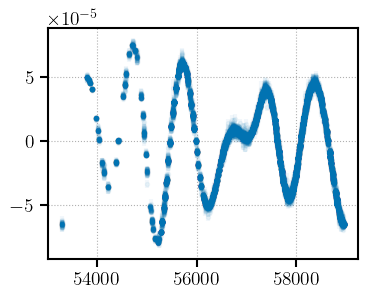

In [76]:
plt.errorbar(psr.toas / 86400, psr.residuals, yerr=psr.toaerrs, fmt='.', alpha=0.05)

In [87]:
model, gl = lncass_models.create_rn_single_psr_model_javier(psr, n_rn_freqs, cond=0)

(201,) (200,) (200, 201)


In [88]:
lncass_outliers_sampler = infer.MCMC(
    infer.NUTS(model, max_tree_depth=10),
    num_warmup=500,
    num_samples=500,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [89]:
with numpyro.validation_enabled():
    lncass_outliers_sampler.run(jax.random.PRNGKey(35))
    # lncass_outliers_sampler.run(jax.random.PRNGKey(35), prior_dict={**PRIOR_DICT, 'tau': dist.Uniform(9.99, 10.01), 'sigma_lambda':dist.Uniform(14.999, 15.001),
                                                                    # 'mu_lambda': dist.Uniform(-0.001, 0.001)})


sample: 100%|██████████| 1000/1000 [03:46<00:00,  4.41it/s, 1023 steps of size 5.39e-03. acc. prob=0.92]


In [90]:
samples = lncass_outliers_sampler.get_samples()

In [91]:
lncass_outliers_sampler.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
     log_10_rho_0     -4.81      0.50     -4.71     -5.56     -4.02    264.08      1.00
  log_10_rho_last    -11.75      2.06    -11.93    -14.98     -8.69    493.50      1.00
          u_rn[0]      0.51      0.10      0.52      0.36      0.68    339.93      1.00
          u_rn[1]      0.74      0.15      0.77      0.51      0.97    291.58      1.00
          u_rn[2]      0.37      0.18      0.36      0.09      0.68    357.39      1.00
          u_rn[3]      0.40      0.20      0.39      0.07      0.70    401.61      1.00
          u_rn[4]      0.22      0.15      0.19      0.00      0.41    314.58      1.00
          u_rn[5]      0.52      0.24      0.54      0.17      0.97    331.78      1.00
          u_rn[6]      0.54      0.23      0.56      0.16      0.93    382.55      1.00
          u_rn[7]      0.49      0.23      0.49      0.07      0.83    398.10      1.00
          u_rn[8]      0.46    

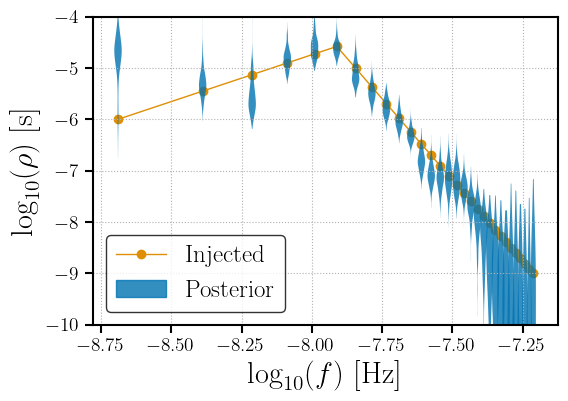

In [92]:
plt.figure(figsize=(6, 4))
parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15])
for b in parts['bodies']:
    b.set_alpha(0.8)
# plt.plot(np.log10(freqs),  , '-o', lw=1)
plt.plot(np.log10(freqs), injection, '-o', lw=1, label='Injected', zorder=-100)
plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
plt.xlabel("$\log_{10}(f)$ [Hz]")
plt.ylabel("$\log_{10}(\\rho)$ [s]")
plt.ylim(-10, -4)
plt.legend()
plt.savefig("../plots/single_pulsar_broken_powerlaw_injection_recovery.pdf")
plt.show()

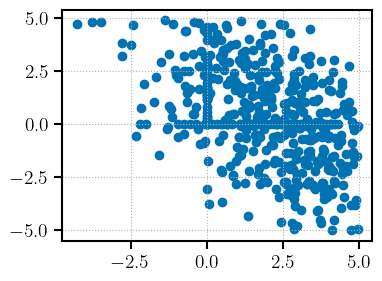

In [93]:
plt.scatter(samples['beta_rn'][:, 9], samples['beta_rn'][:, 8])
# plt.scatter(, bins='auto')
plt.show()

In [84]:
n, bins = np.histogram(samples['beta_rn'][:, 30], bins='auto')
print((np.sum(n) - np.max(n)) / np.max(n))

1.5


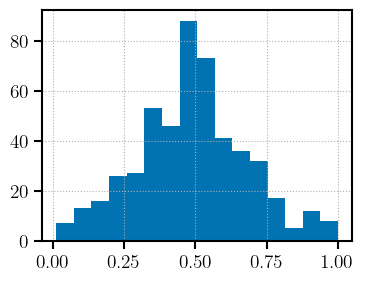

In [86]:
plt.hist(samples['alpha_rn'], bins='auto')
plt.show()

[0.47424776 0.4627254  0.44141443 0.45271097 0.43263336 0.42248816
 0.42248816 0.43503666 0.43155312 0.44552059 0.45852145 0.48459614
 0.47446107 0.49112097 0.46740152 0.48709191 0.49642233 0.49504002
 0.48117084 0.46243341 0.45153224 0.47014052 0.42781336 0.42781336
 0.44284377 0.45523522 0.45806361 0.49631747 0.4135483  0.39336104
 0.44369107 0.46589311 0.48640632 0.46156476 0.46895616 0.37708471
 0.37803676 0.37803676 0.38756118 0.38571311 0.3720769  0.32995859]
[38.50423974 11.53338813 11.66125349 12.87545083 12.85434628 12.88448779
 12.88448779 11.81750872 33.57288199 34.52225568 34.79029298 35.05630988
 35.03435188 11.32088641 10.21095911  9.67277462 27.13080748 27.06998887
 29.32176611 10.3276061  10.27879219 10.27271063 10.2794107  10.2794107
 10.20631705 10.25117598 10.35549823  8.59748583 21.49923536 21.41858499
 26.98964061 27.88290101 27.16716336 25.27076028 46.47893568 20.68259361
 24.06437917 24.06437917 23.11260733 23.00560258 22.76012968 20.41167622]


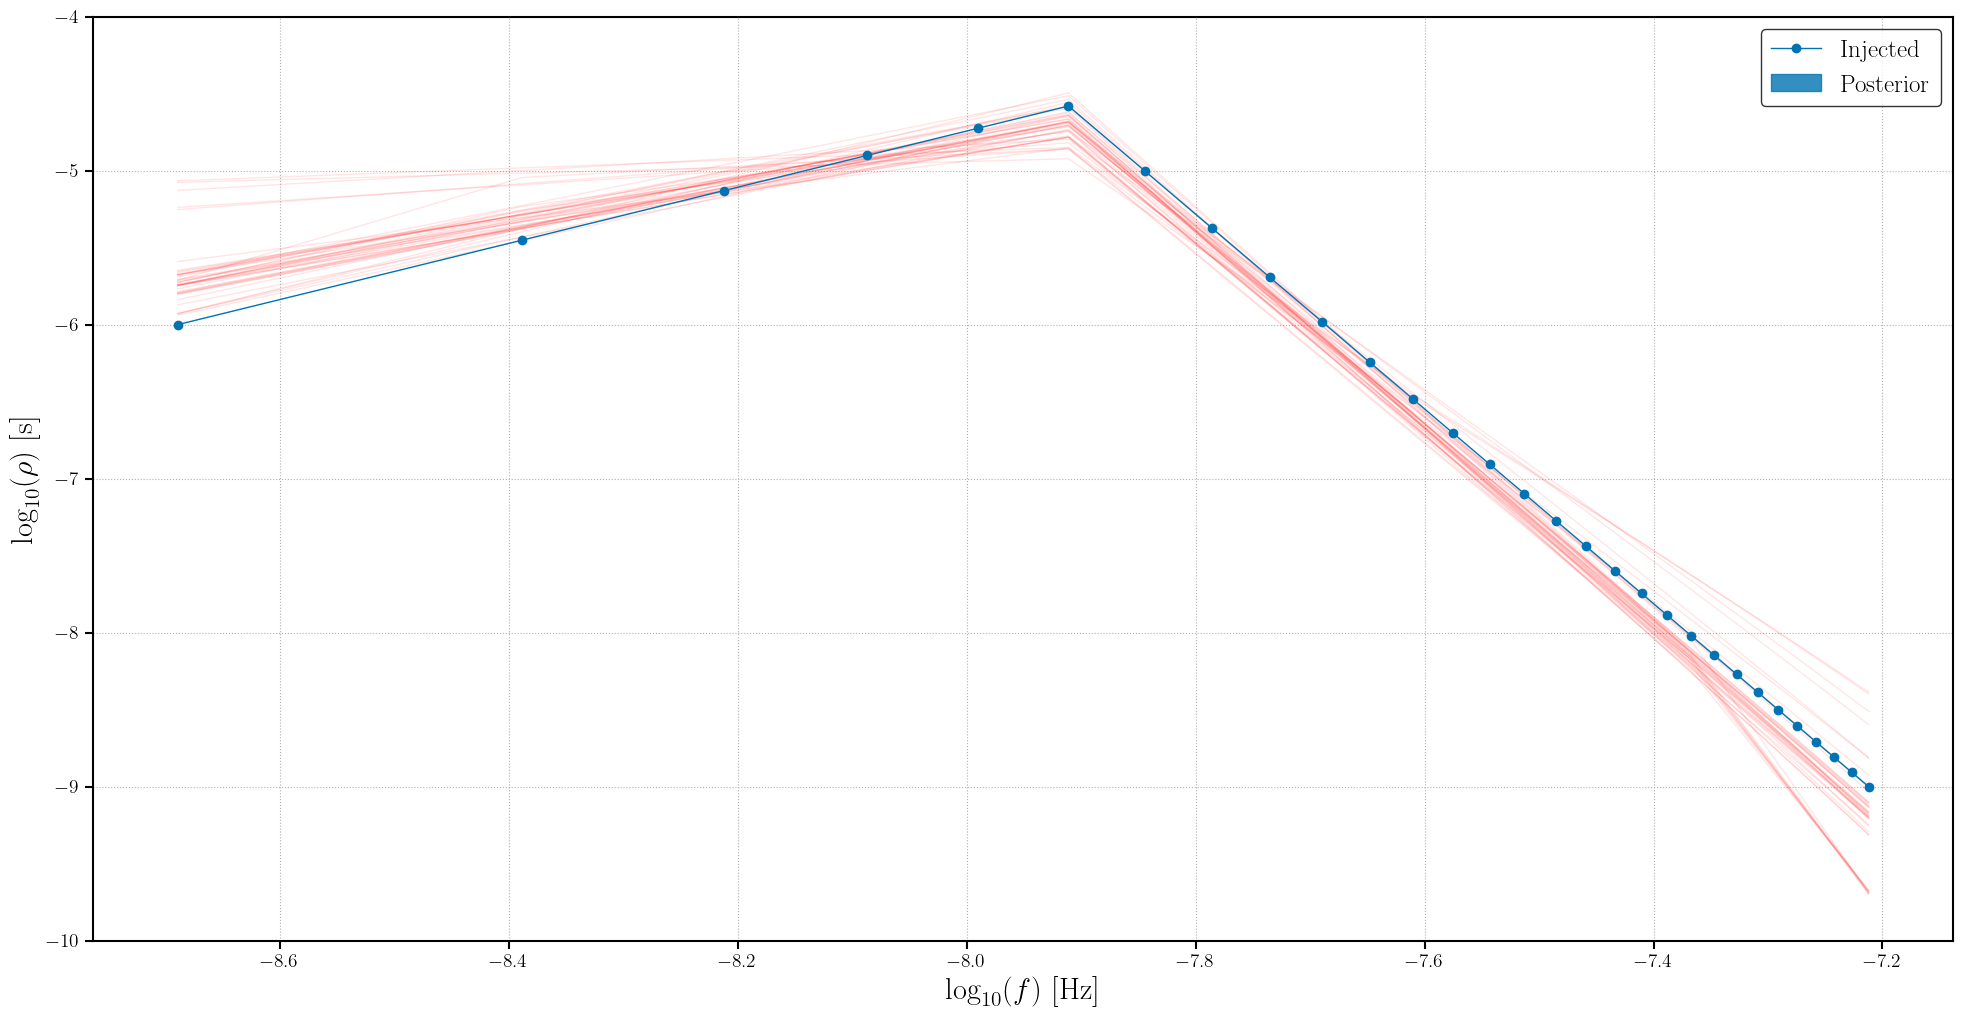

In [141]:
n_betas = np.sum(samples['lambdas_rn'] > 0.5, axis=1)
all_betas_zero_indexes = np.where(n_betas==0)[0]
print(samples['lambdas_rn'][all_betas_zero_indexes, 4])
print(samples['sigma_lambda_rn'][all_betas_zero_indexes])
plt.figure(figsize=(24, 12))
# parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15])
for idx in all_betas_zero_indexes:
    plt.plot(np.log10(freqs), samples['log10_rho'][idx],  lw=1, alpha=0.1, c='r')
plt.plot(np.log10(freqs), injection, '-o', lw=1, label='Injected', zorder=100)
plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
plt.xlabel("$\log_{10}(f)$ [Hz]")
plt.ylabel("$\log_{10}(\\rho)$ [s]")
plt.ylim(-10, -4)
plt.legend()
plt.savefig("../plots/single_pulsar_broken_powerlaw_injection_recovery.pdf")
plt.show()

In [ ]:
plt.figure(figsize=(24, 12))
# parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15])
for ii in range(1000):
    plt.plot(np.log10(freqs), samples['log10_rho'][ii],  lw=1, alpha=0.1, c='r')
plt.plot(np.log10(freqs), injection, '-o', lw=1, label='Injected', zorder=100)
plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
plt.xlabel("$\log_{10}(f)$ [Hz]")
plt.ylabel("$\log_{10}(\\rho)$ [s]")
plt.ylim(-10, -4)
plt.legend()
plt.savefig("../plots/single_pulsar_broken_powerlaw_injection_recovery.pdf")
plt.show()

In [124]:
import pandas as pd
pandas_dict = {}
pandas_dict['amplitude'] = []
pandas_dict['frequency'] = []
for ii,col in enumerate(samples['beta_rn'].T):
    pandas_dict['amplitude'].extend(samples['beta_rn'][:, ii].tolist())
    pandas_dict['frequency'].extend((np.log10(freqs[ii]) * np.ones_like(samples['beta_rn'][:, ii])).tolist())
df = pd.DataFrame(pandas_dict)

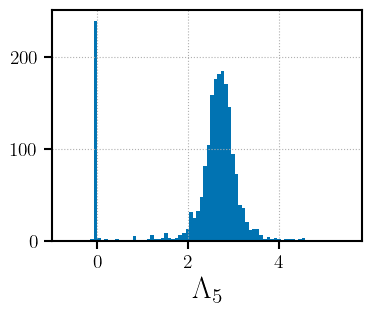

6.968127490039841


In [125]:
plt.hist(samples['beta_rn'][:, 4], bins='auto')
plt.xlabel("$\Lambda_5$")
plt.savefig("../plots/single_pulsar_broken_powerlaw_lambda_5_example.pdf")
plt.show()
print(np.sum(samples['lambdas_rn'][:, 4] > 0.25) / np.sum(samples['lambdas_rn'][:, 4] < 0.25))


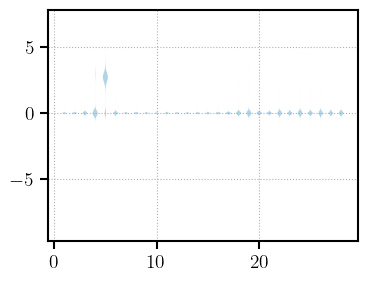

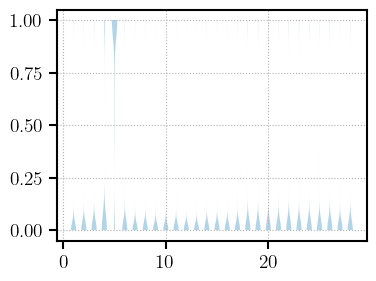

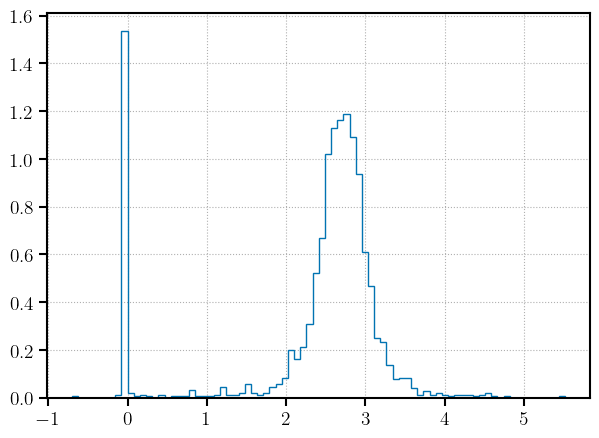

In [126]:
plt.violinplot(samples['beta_rn'], showextrema=False)
plt.show()
plt.violinplot(samples['lambdas_rn'], showextrema=False)
plt.show()
plt.figure(figsize=(7, 5))
bins='auto' # np.linspace(-3, 3, num=100)
plt.hist(samples['beta_rn'][:, 4], bins=bins, histtype='step', density=True)
plt.show()
# plt.hist(samples['beta_rn'][:, 5], bins=bins, histtype='step', density=True)
# plt.hist(samples['beta_rn'][:, 20], bins=bins, histtype='step', density=True)
# plt.yscale("log")
plt.show()
# plt.hist(samples['lambdas_rn'][:, 4], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# plt.hist(samples['lambdas_rn'][:, 5], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# n, bins, patches = plt.hist(samples['lambdas_rn'][:, 20], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# print(n[0] / n[-1])

In [127]:
pinc = np.clip((samples['lambdas_rn'][:, 4] > 0.5).astype(int) + (samples['lambdas_rn'][:, 3] > 0.5).astype(int) + (samples['lambdas_rn'][:, 5] > 0.5).astype(int), 0, 1).mean()
print(pinc / (1 - pinc))

30.24999999999997


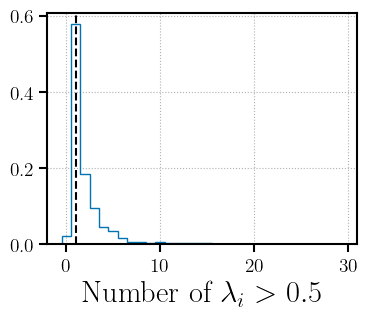

1.9535
46.61904761904762


In [128]:
n, bins, patches = plt.hist(np.sum(samples['lambdas_rn'] > 0.5, axis=1), bins=np.arange(0, 31)-0.5, histtype='step', density=True)
plt.xlabel("Number of $\\lambda_i > 0.5$")
ax = plt.gca()
ax.axvline(1, c='k', ls='--', lw=1.5)
plt.show()
print(np.mean(np.sum(samples['lambdas_rn'] > 0.5, axis=1)))

print(np.sum(n[1:]) / (n[0]))


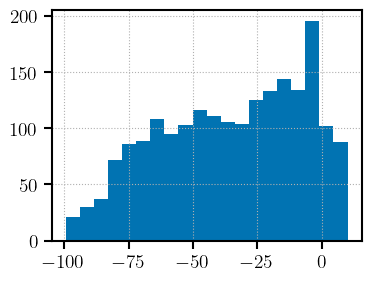

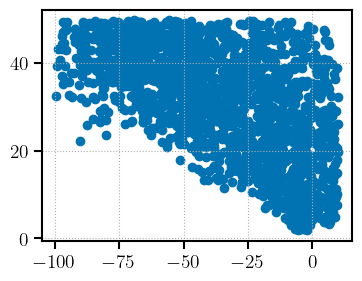

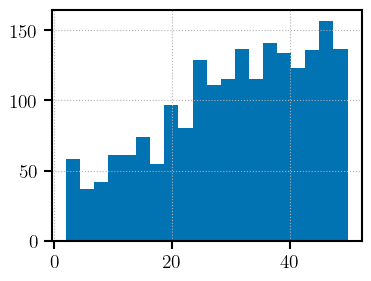

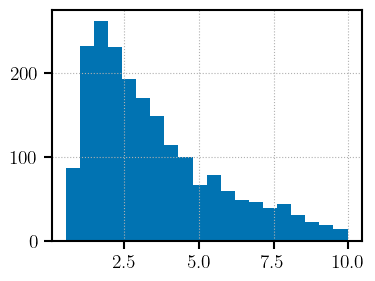

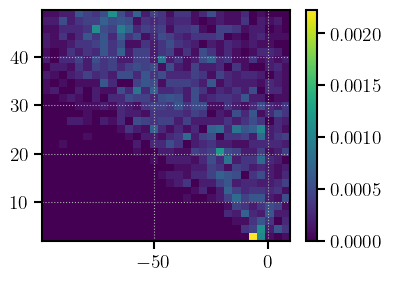

In [100]:
plt.hist((samples['mu_lambda_rn']), bins=20)
plt.show()
plt.scatter(samples['mu_lambda_rn'], samples['sigma_lambda_rn'])
plt.show()
plt.hist((samples['sigma_lambda_rn']), bins=20)
plt.show()
plt.hist((samples['tau_rn']), bins=20)
plt.show()
plt.hist2d(samples['mu_lambda_rn'], samples['sigma_lambda_rn'], bins=30, density=True)
plt.colorbar()
plt.show()

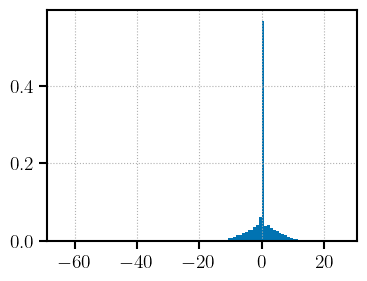

In [159]:
unif = dist.Normal(0, 5)
cauchy = dist.Cauchy(0, 0.01)
cat = dist.Categorical(jnp.array([0.5, 0.5]))
pat = dist.Mixture(cat, [unif, cauchy])


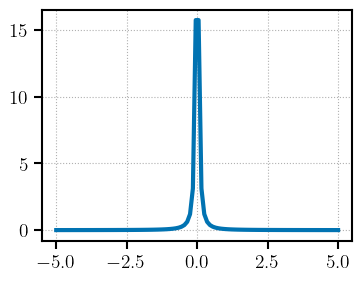

In [151]:

pat = dist.Cauchy(0, 0.01)
plt.plot(np.linspace(-5, 5, num=100), np.exp(pat.log_prob(np.linspace(-1, 1, num=100))))
plt.show()


In [65]:
from scipy.special import expit
def plot_lncass_priors(samples, tag='rn'):
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    axes = axes.ravel()
    # histogram sigma_lambda_rn
    axes[0].hist(samples[f'sigma_lambda_{tag}'], bins='auto', density=True, histtype='stepfilled', color='b', alpha=0.5)
    axes[0].set_title(f'$\\sigma_{{\\lambda_{{ {tag} }}}}$')
    # histogram mu_lambda_rn
    axes[1].hist(samples[f'mu_lambda_{tag}'], bins='auto', density=True, histtype='stepfilled', color='b', alpha=0.5)
    axes[1].set_title(f'$\\mu_{{\\lambda_{{ {tag} }}}}$')
    # get prior on b's
    lam_prior_vals = []
    b_prior_vals = []
    for ii in range(1000):
        idx = np.random.randint(0, samples[f'tau_{tag}'].shape[0])
        lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_{tag}'][idx] + samples[f'mu_lambda_{tag}'][idx])
        lam_prior_vals.extend(lam_prior.tolist())
        bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_{tag}'][idx]
        b_prior_vals.extend(bvals)
    lam_prior_vals = np.array(lam_prior_vals)

    b_prior_vals = np.array(b_prior_vals)
    axes[2].hist(lam_prior_vals.flatten(), bins=50, density=True, histtype='step', color='b', alpha=0.5)
    axes[2].set_title(f'$\\lambda_{{ {tag} }}$ Prior')
    axes[2].set_yscale("log")
    # axes[2].set_xscale("log")
    axes[3].hist(b_prior_vals.flatten(), bins=200, density=True, histtype='step', color='b', alpha=0.5)
    axes[3].set_yscale("log")
    # axes[3].set_ylim(0, )
    axes[3].set_title(f'$b_{{ {tag} }}$ Prior')
    plt.tight_layout()
    plt.show()

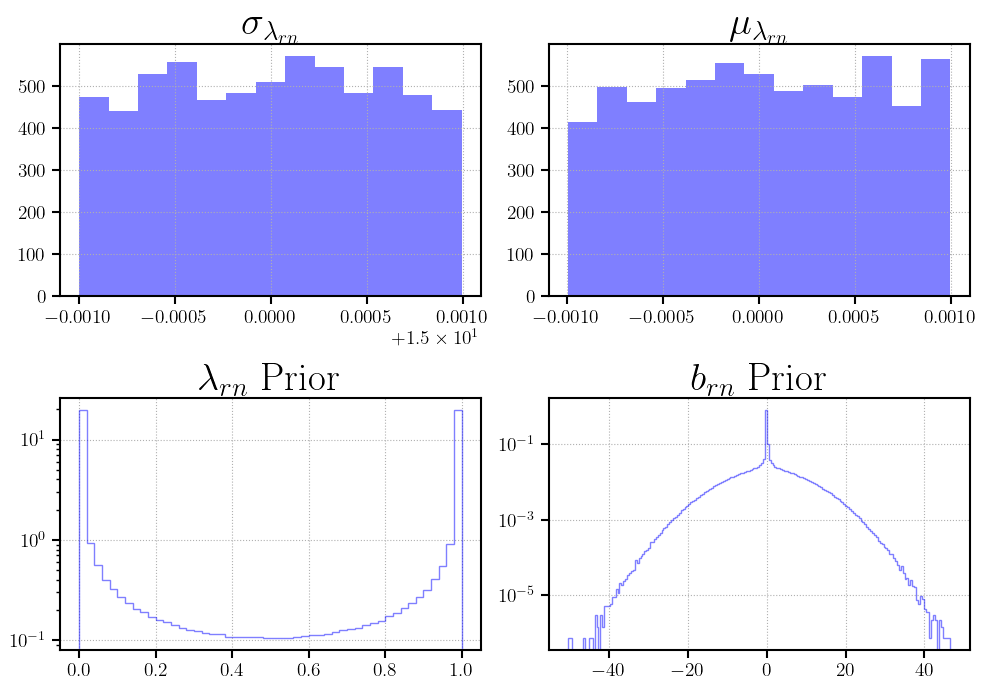

In [66]:
plot_lncass_priors(samples)
# plot_lncass_priors(samples, tag='o')


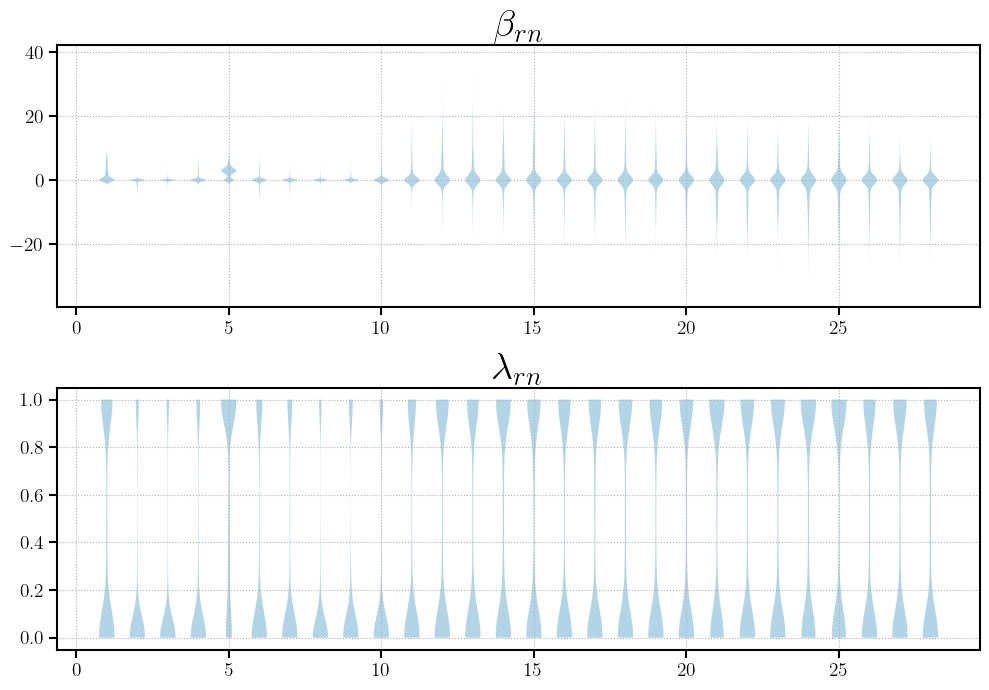

In [67]:

import matplotlib.gridspec as gridspec

def plot_lncass_posteriors(samples, tag='rn'):
    fig, axes = plt.subplots(2, 1, figsize=(10, 7))
    axes = axes.ravel()
    axes[0].violinplot(samples[f'beta_{tag}'], showextrema=False)
    axes[0].set_title(f'$\\beta_{{ {tag} }}$')
    
    axes[1].violinplot(samples[f'lambdas_{tag}'], showextrema=False)
    axes[1].set_title(f'$\\lambda_{{ {tag} }}$')
    
    plt.tight_layout()
    plt.show()

plot_lncass_posteriors(samples)
# plot_lncass_posteriors(samples, tag='o')

In [68]:
pl_model = lncass_models.create_single_psr_powerlaw_model(psr, n_rn_freqs)
pl_sampler = infer.MCMC(
    infer.NUTS(pl_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [69]:
with numpyro.validation_enabled():
    pl_sampler.run(jax.random.PRNGKey(13))

ValueError: Expected `fn` to be a Python callable object; instead found type(fn) = <class 'tuple'>.

In [ ]:
pl_sampler.print_summary()

In [ ]:
fspec_model = lncass_models.create_single_psr_freespec_model(psr, n_rn_freqs)
fspec_sampler = infer.MCMC(
    infer.NUTS(fspec_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
with numpyro.validation_enabled():
    fspec_sampler.run(jax.random.PRNGKey(13))

In [ ]:
fspec_sampler.print_summary()

In [ ]:
fspec_samples = fspec_sampler.get_samples()
pl_samples = pl_sampler.get_samples()

In [ ]:
pl_samples.keys()

In [ ]:
freqs = np.arange(1, 31) / ds.getspan([psr])
fyr = 1 / 365.25 / 86400
pl_rhos = np.array([np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2  for idx in range(1000)])

In [ ]:
pl_rhos.shape

In [ ]:
plt.figure(figsize=(10, 4))
plt.violinplot(fspec_samples['log10_rho'].squeeze(), showextrema=False, side="low", widths=0.9)
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, side="high", widths=0.9)
freqs = np.arange(1, 31) / ds.getspan([psr])
plt.plot(np.arange(1, n_rn_freqs+1), injection, '-o', lw=1)

plt.ylim(-8, -4)

for ii in range(500):
    idx = np.random.randint(0, pl_samples['log10_A'].shape[0])
    tr = np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2
    plt.plot(np.arange(1, 31), tr, c='k', alpha=0.002, zorder=-1000)

# Direct deviation from power law

In [ ]:
spline_model = lncass_models.create_rn_single_psr_spline_model(psr, n_rn_freqs, 20)
spline_sampler = infer.MCMC(
    infer.NUTS(spline_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
with numpyro.validation_enabled():
    spline_sampler.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT})

In [ ]:
spline_sampler.print_summary()

In [ ]:
spline_samples = spline_sampler.get_samples()

In [ ]:
plt.figure(figsize=(10, 8))
plt.violinplot(spline_samples['log10_rho'].squeeze(), showextrema=False, side="low", widths=0.9)
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, side="high", widths=0.9)
# plt.violinplot(pl_rhos, showextrema=False, side="high", widths=0.9)
plt.ylim(-8, -2)
plt.plot(np.arange(1, n_rn_freqs+1),  injection, '-o')
# for ii in range(1000):
#     idx = np.random.randint(0, pl_samples['log10_A'].shape[0])
#     tr = np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2
#     plt.plot(np.arange(1, 31), tr, c='k', alpha=0.002, zorder=-1000)
plt.show()

In [ ]:
plt.violinplot(spline_samples['beta_rn'].squeeze(), showextrema=False, widths=0.9)
plt.ylim(-2, 2)
plt.show()